In [ ]:
import json

def evaluate_ner_performance(gold_standard_path, generated_path):
    """
    Compares a generated JSON to a gold standard JSON to calculate NER performance.
    """
    with open(gold_standard_path, 'r') as f:
        gold_data = json.load(f)

    with open(generated_path, 'r') as f:
        generated_data = json.load(f)

    # Convert to sets of (key, value) tuples for easy comparison
    gold_entities = set(gold_data.items())
    generated_entities = set(generated_data.items())

    # Calculate TP, FP, FN
    true_positives = len(gold_entities.intersection(generated_entities))
    false_positives = len(generated_entities - gold_entities)
    false_negatives = len(gold_entities - generated_entities)
    
    # print(f"True Positives: {gold_entities.intersection(generated_entities)}")
    # print(f"False Positives: {generated_entities - gold_entities}")
    # print(f"False Negatives: {gold_entities - generated_entities}")

    # Calculate overall metrics
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # print("--- Overall Performance ---")
    # print(f"Precision: {precision:.4f}")
    # print(f"Recall: {recall:.4f}")
    # print(f"F1-Score: {f1_score:.4f}\n")

    # Calculate per-class metrics
    all_labels = sorted(list(set(gold_data.values()) | set(generated_data.values())))
    print("--- Performance Per Entity Type ---")
    for label in all_labels:
        gold_for_label = {k for k, v in gold_entities if v == label}
        gen_for_label = {k for k, v in generated_entities if v == label}

        tp_label = len(gold_for_label.intersection(gen_for_label))
        fp_label = len(gen_for_label - gold_for_label)
        fn_label = len(gold_for_label - gen_for_label)

        precision_label = tp_label / (tp_label + fp_label) if (tp_label + fp_label) > 0 else 0
        recall_label = tp_label / (tp_label + fn_label) if (tp_label + fn_label) > 0 else 0
        f1_label = 2 * (precision_label * recall_label) / (precision_label + recall_label) if (precision_label + recall_label) > 0 else 0
        support = len(gold_for_label)

        # print(f"Label: {label}")
        # print(f"\tPrecision: {precision_label:.4f}, Recall: {recall_label:.4f}, F1-Score: {f1_label:.4f}, Support: {support}")

# Example usage:
evaluate_ner_performance('data/original_json/Schnitzler.json', 'LLM_output/openai/gpt-oss-20b/Schnitzler.json')

True Positives: {('Universitätsklinikum Klagenfurt', 'LOCATION_HOSPITAL'), ('17663757', 'ID'), ('Alois-Alzheimer-Gasse 21', 'LOCATION_STREET'), ('1502', 'ID'), ('37844677', 'ID'), ('Adalbert Schitzler', 'NAME_DOCTOR'), ('17217277', 'ID'), ('Klagenfurt', 'LOCATION_CITY'), ('9020', 'LOCATION_ZIP'), ('Albert Schnitzler', 'NAME_PATIENT'), ('2.05.2023', 'DATE'), ('19.4.2023', 'DATE')}
False Positives: {('3.2.1959', 'DATE_BIRTH'), ('Dr.', 'NAME_TITLE'), ('2023-04-26', 'DATE')}
False Negatives: {('3.2.1959', 'DATE'), ('2018', 'DATE'), ('Schnitzler', 'NAME_PATIENT'), ('2023-04-26', 'DATE_BIRTH'), ('Dr. med. univers.', 'NAME_TITLE')}
--- Overall Performance ---
Precision: 0.8000
Recall: 0.7059
F1-Score: 0.7500

--- Performance Per Entity Type ---
Label: DATE
	Precision: 0.6667, Recall: 0.5000, F1-Score: 0.5714, Support: 4
Label: DATE_BIRTH
	Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000, Support: 1
Label: ID
	Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000, Support: 4
Label: LOCATION_C

In [5]:
import json
import os
from collections import defaultdict
import pandas as pd

def evaluate_ner_performance(gold_standard_path, generated_path):
    """
    Compares a generated JSON to a gold standard JSON to calculate NER performance
    and provide data for a confusion matrix using a "strict" evaluation methodology.

    This function defines performance metrics as follows:
    - True Positive (TP): An entity is counted as a TP if, and only if, the predicted
      entity text and its assigned label are both an EXACT match with an entity in
      the gold standard.
    - False Positive (FP): An entity is counted as an FP if it is present in the
      generated output but not in the gold standard. This includes:
        1. An entirely incorrect entity (spurious prediction).
        2. A correct entity text with an incorrect label.
        3. A correct label but with incorrect text boundaries (e.g., "Klinikum"
           instead of "Universitätsklinikum Klagenfurt").
    - False Negative (FN): An entity is counted as an FN if it is present in the
      gold standard but was not predicted by the model. This includes:
        1. A completely missed entity.
        2. Cases where the model's prediction was counted as an FP due to an
           incorrect label or boundary, meaning the correct gold standard entity
           was effectively missed.

    Args:
        gold_standard_path (str): The file path to the gold standard JSON.
        generated_path (str): The file path to the model's generated JSON.

    Returns:
        dict: A dictionary containing raw counts for true positives, false positives,
              false negatives, and detailed data for building a confusion matrix.
              Returns None if a file cannot be opened.
    """
    try:
        with open(gold_standard_path, 'r', encoding='utf-8') as f:
            gold_data = json.load(f)

        with open(generated_path, 'r', encoding='utf-8') as f:
            generated_data = json.load(f)
    except FileNotFoundError as e:
        print(f"Error opening file: {e}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from a file: {e}")
        return None

    # Use maps for quick lookups: {text: label}
    gold_map = {k: v for k, v in gold_data.items()}
    gen_map = {k: v for k, v in generated_data.items()}

    all_entity_texts = set(gold_map.keys()) | set(gen_map.keys())
    all_labels = set(gold_map.values()) | set(gen_map.values())

    # Initialize stats containers
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    confusion_data = [] # List of (gold_label, predicted_label) tuples

    for text in all_entity_texts:
        gold_label = gold_map.get(text)
        gen_label = gen_map.get(text)

        if gold_label and gen_label and gold_label == gen_label:
            # This is a True Positive
            true_positives += 1
            confusion_data.append((gold_label, gen_label))
        elif gold_label and gen_label and gold_label != gen_label:
            # Correct text, wrong label -> 1 FP and 1 FN
            false_positives += 1
            false_negatives += 1
            confusion_data.append((gold_label, gen_label))
        elif gen_label and not gold_label:
            # Spurious prediction (not in gold standard) -> 1 FP
            false_positives += 1
            confusion_data.append(('SPURIOUS_PREDICTION', gen_label))
        elif gold_label and not gen_label:
            # Missed prediction -> 1 FN
            false_negatives += 1
            confusion_data.append((gold_label, 'NOT_PREDICTED'))

    return {
        "tp": true_positives,
        "fp": false_positives,
        "fn": false_negatives,
        "confusion_data": confusion_data,
        "all_labels": all_labels
    }


gold_dir = 'data/original_json'
pred_dir = 'LLM_output/openai/gpt-oss-20b'

# --- Aggregators for Corpus-Wide Stats ---
corpus_tp = 0
corpus_fp = 0
corpus_fn = 0
all_corpus_labels = set()
confusion_matrix = defaultdict(lambda: defaultdict(int))

# --- Iterate and Evaluate Each File ---
gold_files = [f for f in os.listdir(gold_dir) if f.endswith('.json')]

for filename in gold_files:
    gold_path = os.path.join(gold_dir, filename)
    pred_path = os.path.join(pred_dir, filename)

    if not os.path.exists(pred_path):
        print(f"Warning: Prediction file not found for '{filename}'. Skipping.")
        continue

    results = evaluate_ner_performance(gold_path, pred_path)

    if results:
        corpus_tp += results['tp']
        corpus_fp += results['fp']
        corpus_fn += results['fn']
        all_corpus_labels.update(results['all_labels'])

        for gold_label, pred_label in results['confusion_data']:
            confusion_matrix[gold_label][pred_label] += 1

# --- Calculate Corpus-Wide Metrics ---
precision = corpus_tp / (corpus_tp + corpus_fp) if (corpus_tp + corpus_fp) > 0 else 0
recall = corpus_tp / (corpus_tp + corpus_fn) if (corpus_tp + corpus_fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("--- Corpus-Wide Performance (Micro-Average) ---")
print(f"Total True Positives:  {corpus_tp}")
print(f"Total False Positives: {corpus_fp}")
print(f"Total False Negatives: {corpus_fn}\n")
print(f"Overall Precision: {precision:.4f}")
print(f"Overall Recall:    {recall:.4f}")
print(f"Overall F1-Score:  {f1_score:.4f}")
print("-" * 50)

# --- Build and Display the Confusion Matrix ---
sorted_labels = sorted(list(all_corpus_labels))
matrix_labels = sorted_labels + ['SPURIOUS_PREDICTION']
matrix_columns = sorted_labels + ['NOT_PREDICTED']

# Create a DataFrame for pretty printing
df = pd.DataFrame(
    [[confusion_matrix[row][col] for col in matrix_columns] for row in matrix_labels],
    index=matrix_labels,
    columns=matrix_columns
).fillna(0).astype(int)

# Add row and column for totals to get per-class stats
df['TOTAL_GOLD'] = df.sum(axis=1) # Support for each true label

print("Rows: True Labels, Columns: Predicted Labels\n")
print(df.to_string())
print("-" * 50)

# --- Per-Class Performance Metrics ---
print("\n--- Performance Per Entity Type ---")
class_metrics = []
for label in sorted_labels:
    class_tp = df.at[label, label] if label in df.index and label in df.columns else 0
    class_fn = df.loc[label, 'TOTAL_GOLD'] - class_tp
    class_fp = df[label].sum() - class_tp
    support = int(df.loc[label, 'TOTAL_GOLD'])

    p = class_tp / (class_tp + class_fp) if (class_tp + class_fp) > 0 else 0
    r = class_tp / (class_tp + class_fn) if (class_tp + class_fn) > 0 else 0
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    
    class_metrics.append({
        "Entity Type": label,
        "Precision": f"{p:.4f}",
        "Recall": f"{r:.4f}",
        "F1-Score": f"{f1:.4f}",
        "Support": support # Number of instances in gold standard
    })

per_class_df = pd.DataFrame(class_metrics)
print(per_class_df.to_string(index=False))
print("-" * 50)

--- Corpus-Wide Performance (Micro-Average) ---
Total True Positives:  786
Total False Positives: 167
Total False Negatives: 414

Overall Precision: 0.8248
Overall Recall:    0.6550
Overall F1-Score:  0.7301
--------------------------------------------------
Rows: True Labels, Columns: Predicted Labels

                       AGE  CONTACT_EMAIL  CONTACT_FAX  CONTACT_PHONE  DATE  DATE_BIRTH  ID  LOCATION_CITY  LOCATION_COUNTRY  LOCATION_HOSPITAL  LOCATION_ORGANIZATION  LOCATION_STREET  LOCATION_ZIP  NAME_DOCTOR  NAME_EXT  NAME_PATIENT  NAME_RELATIVE  NAME_TITLE  NAME_USERNAME  OTHER  PROFESSION  NOT_PREDICTED  TOTAL_GOLD
AGE                      6              0            0              0     0           0   0              0                 0                  0                      0                0             0            0         0             0              0           0              0      0           0             12          18
CONTACT_EMAIL            0              1        

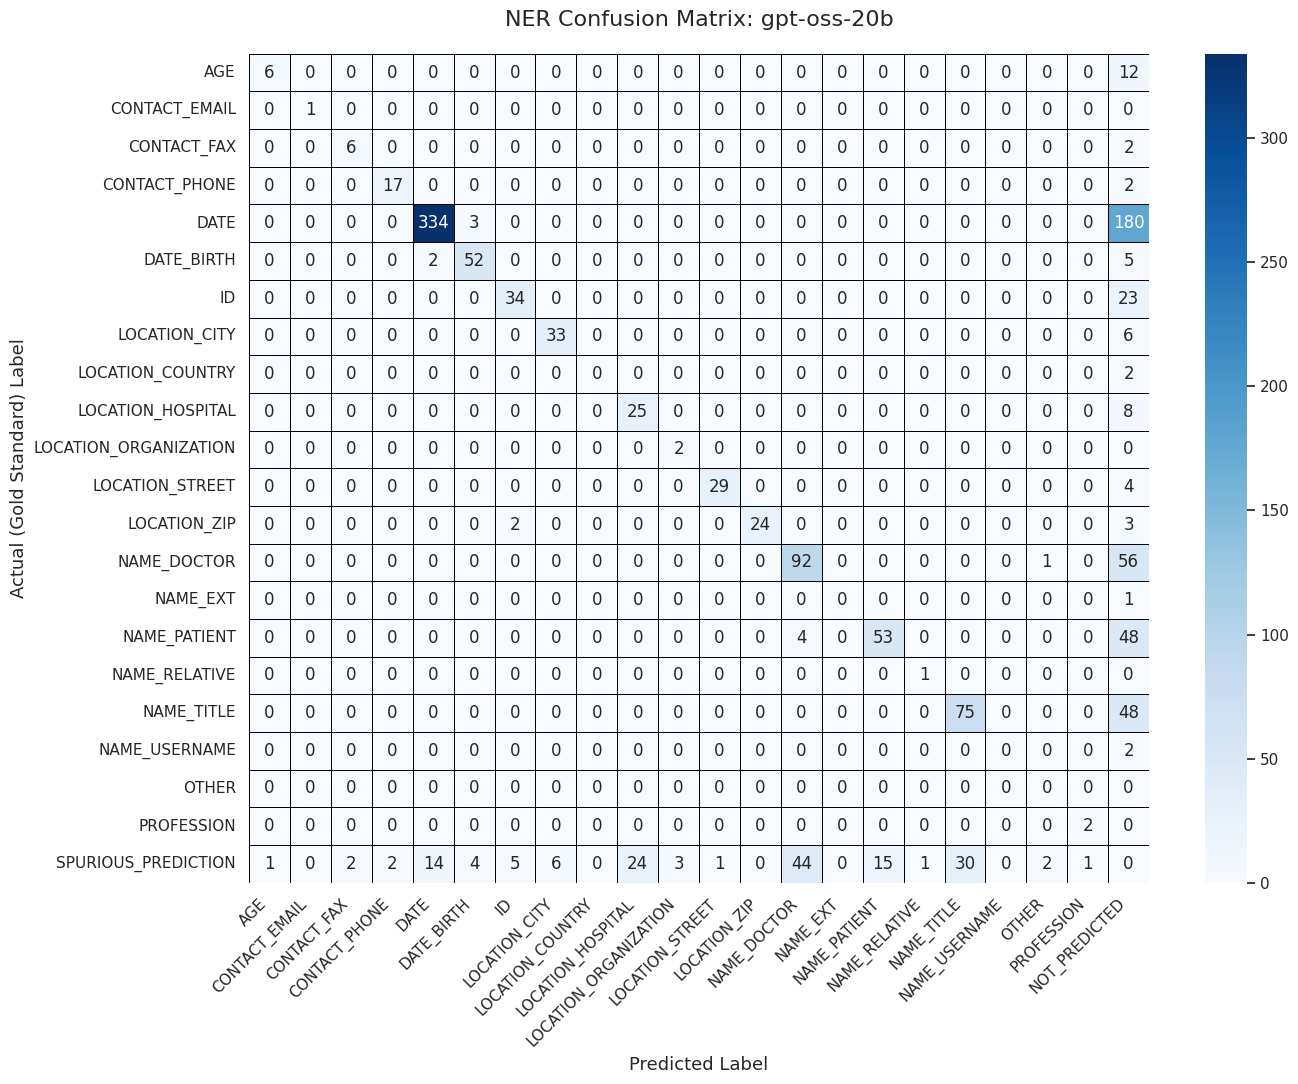

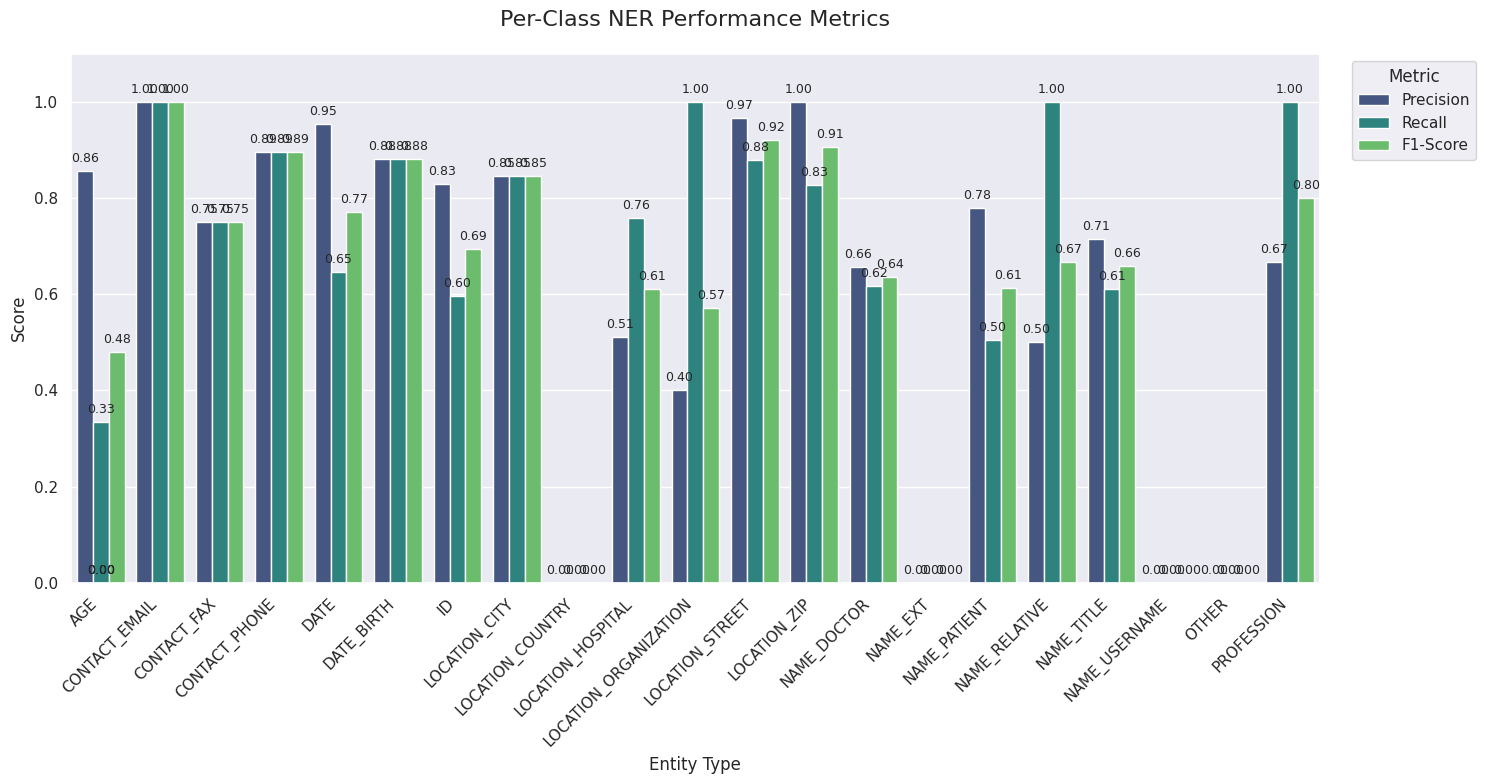

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a Colored Confusion Matrix Heatmap 
# We will use the 'df' DataFrame, but drop the 'TOTAL_GOLD' column for the plot
try:
    df_plot = df.drop('TOTAL_GOLD', axis=1)
    
    plt.figure(figsize=(14, 11))
    sns.set(font_scale=1.0) # Adjust font size for readability
    
    heatmap = sns.heatmap(
        df_plot,
        annot=True,          # Display the numbers in each cell
        fmt='d',             # Format numbers as integers
        cmap='Blues',        # Use a blue color scheme
        linewidths=.5,       # Add lines between cells
        linecolor='black'    # Line color
    )
    
    plt.ylabel('Actual (Gold Standard) Label', fontsize=13)
    plt.xlabel('Predicted Label', fontsize=13)
    plt.title('NER Confusion Matrix: gpt-oss-20b', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
    plt.yticks(rotation=0)
    plt.tight_layout() # Ensure everything fits without overlapping
    
    # Save the figure to a file
    plot_filename = os.path.join("eval_results", 'confusion_matrix_heatmap.png')
    plt.savefig(plot_filename)
    
    # Display the plot
    plt.show()

except Exception as e:
    print(f"\n Could not generate the confusion matrix plot. Error: {e}")


# Plot Per-Class Performance Metrics (Bar Chart)
# We will use the 'per_class_df' DataFrame for this plot
try:
    # Convert metric columns to numeric type for plotting
    metrics_to_plot = per_class_df.copy()
    metrics_to_plot['Precision'] = pd.to_numeric(metrics_to_plot['Precision'])
    metrics_to_plot['Recall'] = pd.to_numeric(metrics_to_plot['Recall'])
    metrics_to_plot['F1-Score'] = pd.to_numeric(metrics_to_plot['F1-Score'])

    # 'Melt' the DataFrame to prepare it for seaborn's barplot function
    df_melted = metrics_to_plot.melt(
        id_vars='Entity Type',
        value_vars=['Precision', 'Recall', 'F1-Score'],
        var_name='Metric',
        value_name='Score'
    )

    plt.figure(figsize=(15, 8))
    
    barplot = sns.barplot(
        x='Entity Type',
        y='Score',
        hue='Metric',
        data=df_melted,
        palette='viridis' # Use a different color palette
    )
    
    # Add value labels on top of each bar
    for p in barplot.patches:
        barplot.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points',
            fontsize=9
        )
    
    plt.ylim(0, 1.1) # Set y-axis limit to go up to 1.1 for label spacing
    plt.title('Per-Class NER Performance Metrics', fontsize=16, pad=20)
    plt.xlabel('Entity Type', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()

    # Save the figure to a file
    barchart_filename = os.path.join("eval_results", 'per_class_metrics_barchart.png')
    plt.savefig(barchart_filename)

    # Display the plot
    plt.show()

except Exception as e:
    print(f"\nCould not generate the per-class metrics plot. Error: {e}")